In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers = 5
input_size = 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha) #Normalization

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta) #Normalization
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h) #Normalization

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,4].values # Cl values

In [25]:
cl = target_c3.reshape((-1,1))

In [26]:
y = (cl-np.min(cl))/(np.max(cl)-np.min(cl))

In [27]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [28]:
x_train, x_val, x_test, y_train, y_val, y_test, cd_train, cd_val, cd_test = dataset_split(x, y, cl,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [29]:
x_train.shape

(100, 3)

In [30]:
y_train.shape

(100, 1)

In [31]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [32]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
model_directory = "D:\\TrainedModels\\20221230\\steady_parameterOnly"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1000, factor=0.1,
                                          min_delta = 1e-5, min_lr=1e-05, verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 5s 140ms/step - loss: 0.3750 - rmse: 0.6123 - val_loss: 0.3624 - val_rmse: 0.6019 - lr: 1.0000e-04
Epoch 2/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.3118 - rmse: 0.5583 - val_loss: 0.2935 - val_rmse: 0.5417 - lr: 1.0000e-04
Epoch 3/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.2426 - rmse: 0.4925 - val_loss: 0.2242 - val_rmse: 0.4734 - lr: 1.0000e-04
Epoch 4/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.1832 - rmse: 0.4279 - val_loss: 0.1539 - val_rmse: 0.3922 - lr: 1.0000e-04
Epoch 5/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.1203 - rmse: 0.3467 - val_loss: 0.0917 - val_rmse: 0.3027 - lr: 1.0000e-04
Epoch 6/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0773 - rmse: 0.2778 - val_loss: 0.0461 - val_rmse: 0.2144 - lr: 1.0000e-04
Epoch 7/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0506 - rmse: 0.22

Epoch 55/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0079 - rmse: 0.0880 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 56/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0077 - rmse: 0.0872 - val_loss: 0.0071 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 57/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0077 - rmse: 0.0874 - val_loss: 0.0072 - val_rmse: 0.0841 - lr: 1.0000e-04
Epoch 58/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0077 - rmse: 0.0872 - val_loss: 0.0071 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 59/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0076 - rmse: 0.0864 - val_loss: 0.0070 - val_rmse: 0.0830 - lr: 1.0000e-04
Epoch 60/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0075 - rmse: 0.0860 - val_loss: 0.0070 - val_rmse: 0.0829 - lr: 1.0000e-04
Epoch 61/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0075 - rmse

Epoch 109/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0047 - rmse: 0.0678 - val_loss: 0.0052 - val_rmse: 0.0712 - lr: 1.0000e-04
Epoch 110/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0051 - val_rmse: 0.0708 - lr: 1.0000e-04
Epoch 111/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0048 - rmse: 0.0689 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 112/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0045 - rmse: 0.0661 - val_loss: 0.0051 - val_rmse: 0.0704 - lr: 1.0000e-04
Epoch 113/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0044 - rmse: 0.0657 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 114/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0045 - rmse: 0.0660 - val_loss: 0.0049 - val_rmse: 0.0693 - lr: 1.0000e-04
Epoch 115/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0043

5/5 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 163/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0328 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 164/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0325 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 165/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0017 - val_rmse: 0.0404 - lr: 1.0000e-04
Epoch 166/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.8988e-04 - rmse: 0.0299 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 167/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.7436e-04 - rmse: 0.0296 - val_loss: 0.0018 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 168/10000
5/5 [==============================] - 0s 14ms/step - loss: 8.9813e-04 - r

5/5 [==============================] - 0s 13ms/step - loss: 2.5445e-04 - rmse: 0.0126 - val_loss: 8.2648e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 215/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.6337e-04 - rmse: 0.0129 - val_loss: 7.9455e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 216/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.5298e-04 - rmse: 0.0125 - val_loss: 8.5214e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 217/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.3535e-04 - rmse: 0.0118 - val_loss: 8.3107e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 218/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.4215e-04 - rmse: 0.0121 - val_loss: 7.9034e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 219/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.5472e-04 - rmse: 0.0126 - val_loss: 8.2638e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 220/10000
5/5 [=============================

Epoch 265/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.6010e-04 - rmse: 0.0081 - val_loss: 6.2760e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 266/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.4366e-04 - rmse: 0.0070 - val_loss: 6.2368e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 267/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.4321e-04 - rmse: 0.0070 - val_loss: 5.6683e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 268/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.4914e-04 - rmse: 0.0074 - val_loss: 5.9425e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 269/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.3593e-04 - rmse: 0.0064 - val_loss: 5.7396e-04 - val_rmse: 0.0219 - lr: 1.0000e-04
Epoch 270/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.3770e-04 - rmse: 0.0066 - val_loss: 5.9425e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 271/10000
5/5 [=============

Epoch 316/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.3164e-04 - rmse: 0.0062 - val_loss: 4.8987e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 317/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.4860e-04 - rmse: 0.0075 - val_loss: 5.7448e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 318/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.3826e-04 - rmse: 0.0068 - val_loss: 6.2368e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 319/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.5581e-04 - rmse: 0.0080 - val_loss: 5.1125e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 320/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.3599e-04 - rmse: 0.0066 - val_loss: 5.2741e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 321/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.2824e-04 - rmse: 0.0060 - val_loss: 6.4500e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 322/10000
5/5 [=============

Epoch 367/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1470e-04 - rmse: 0.0049 - val_loss: 5.9619e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 368/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.2423e-04 - rmse: 0.0058 - val_loss: 5.1095e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 369/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.2545e-04 - rmse: 0.0059 - val_loss: 5.3532e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 370/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1675e-04 - rmse: 0.0051 - val_loss: 5.4617e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 371/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1883e-04 - rmse: 0.0053 - val_loss: 5.0355e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 372/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1724e-04 - rmse: 0.0052 - val_loss: 5.5665e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 373/10000
5/5 [=============

Epoch 418/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1903e-04 - rmse: 0.0055 - val_loss: 4.6539e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 419/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0446e-04 - rmse: 0.0040 - val_loss: 5.1033e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 420/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1104e-04 - rmse: 0.0048 - val_loss: 4.8929e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 421/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0898e-04 - rmse: 0.0045 - val_loss: 4.3776e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 422/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0026e-04 - rmse: 0.0035 - val_loss: 5.4376e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 423/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1526e-04 - rmse: 0.0052 - val_loss: 4.9507e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 424/10000
5/5 [=============

Epoch 469/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1026e-04 - rmse: 0.0049 - val_loss: 4.8845e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 470/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.1506e-04 - rmse: 0.0053 - val_loss: 4.3758e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 471/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.0840e-04 - rmse: 0.0047 - val_loss: 5.0585e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 472/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.0653e-04 - rmse: 0.0045 - val_loss: 5.0646e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 473/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.1268e-04 - rmse: 0.0051 - val_loss: 5.1211e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 474/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1155e-04 - rmse: 0.0050 - val_loss: 4.1981e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 475/10000
5/5 [=============

Epoch 520/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1855e-04 - rmse: 0.0058 - val_loss: 4.7493e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 521/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1468e-04 - rmse: 0.0055 - val_loss: 3.9285e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 522/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1100e-04 - rmse: 0.0051 - val_loss: 4.1621e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 523/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0254e-04 - rmse: 0.0042 - val_loss: 3.5832e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 524/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0961e-04 - rmse: 0.0050 - val_loss: 4.2240e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 525/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1394e-04 - rmse: 0.0054 - val_loss: 3.6812e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 526/10000
5/5 [=============

Epoch 571/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.6461e-05 - rmse: 0.0037 - val_loss: 4.5174e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 572/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0518e-04 - rmse: 0.0047 - val_loss: 3.9941e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 573/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0398e-04 - rmse: 0.0046 - val_loss: 3.6656e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 574/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.2839e-05 - rmse: 0.0031 - val_loss: 3.8347e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 575/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.7941e-05 - rmse: 0.0039 - val_loss: 3.5762e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 576/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0167e-04 - rmse: 0.0043 - val_loss: 3.7631e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 577/10000
5/5 [=============

Epoch 622/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.7993e-04 - rmse: 0.0099 - val_loss: 3.5312e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 623/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.8693e-04 - rmse: 0.0103 - val_loss: 5.3961e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 624/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.5490e-04 - rmse: 0.0086 - val_loss: 4.1362e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 625/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.2951e-04 - rmse: 0.0069 - val_loss: 3.7806e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 626/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1129e-04 - rmse: 0.0055 - val_loss: 3.8203e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 627/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.6216e-05 - rmse: 0.0039 - val_loss: 4.0058e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 628/10000
5/5 [=============

Epoch 673/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.6438e-05 - rmse: 0.0025 - val_loss: 3.4580e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 674/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.6866e-05 - rmse: 0.0026 - val_loss: 3.5665e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 675/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.6540e-05 - rmse: 0.0026 - val_loss: 3.3783e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 676/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.6915e-05 - rmse: 0.0027 - val_loss: 3.5697e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 677/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.5019e-05 - rmse: 0.0023 - val_loss: 3.3086e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 678/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.4919e-05 - rmse: 0.0023 - val_loss: 3.5786e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 679/10000
5/5 [=============

Epoch 724/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.3625e-05 - rmse: 0.0039 - val_loss: 3.6917e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 725/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.3449e-05 - rmse: 0.0039 - val_loss: 3.7136e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 726/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.3907e-05 - rmse: 0.0023 - val_loss: 3.3749e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 727/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.4615e-05 - rmse: 0.0025 - val_loss: 3.3527e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 728/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.4156e-05 - rmse: 0.0024 - val_loss: 3.1810e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 729/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.4774e-05 - rmse: 0.0025 - val_loss: 3.3109e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 730/10000
5/5 [=============

Epoch 775/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1178e-04 - rmse: 0.0059 - val_loss: 4.1280e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 776/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0894e-04 - rmse: 0.0056 - val_loss: 4.2319e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 777/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1763e-04 - rmse: 0.0064 - val_loss: 4.1275e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 778/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.3307e-04 - rmse: 0.0075 - val_loss: 4.3256e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 779/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1377e-04 - rmse: 0.0061 - val_loss: 3.3174e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 780/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0372e-04 - rmse: 0.0052 - val_loss: 3.9105e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 781/10000
5/5 [=============

Epoch 826/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.1367e-05 - rmse: 0.0023 - val_loss: 3.0143e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 827/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.8761e-05 - rmse: 0.0017 - val_loss: 3.0211e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 828/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.8123e-05 - rmse: 0.0015 - val_loss: 2.9351e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 829/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.9432e-05 - rmse: 0.0019 - val_loss: 3.2195e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 830/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.9965e-05 - rmse: 0.0020 - val_loss: 3.1276e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 831/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.2889e-05 - rmse: 0.0027 - val_loss: 3.3468e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 832/10000
5/5 [=============

Epoch 877/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.2728e-05 - rmse: 0.0028 - val_loss: 2.9512e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 878/10000
5/5 [==============================] - 0s 14ms/step - loss: 8.3866e-05 - rmse: 0.0030 - val_loss: 3.0629e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 879/10000
5/5 [==============================] - 0s 14ms/step - loss: 8.6271e-05 - rmse: 0.0034 - val_loss: 3.0037e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 880/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.6826e-05 - rmse: 0.0035 - val_loss: 2.9286e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 881/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.1541e-05 - rmse: 0.0041 - val_loss: 2.9360e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 882/10000
5/5 [==============================] - 0s 14ms/step - loss: 9.5337e-05 - rmse: 0.0046 - val_loss: 2.6391e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 883/10000
5/5 [=============

Epoch 928/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.5765e-05 - rmse: 0.0015 - val_loss: 2.7586e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 929/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.7556e-05 - rmse: 0.0020 - val_loss: 2.6652e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 930/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.9098e-05 - rmse: 0.0024 - val_loss: 2.8471e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 931/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.7418e-05 - rmse: 0.0020 - val_loss: 2.6265e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 932/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.9031e-05 - rmse: 0.0023 - val_loss: 2.8347e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 933/10000
5/5 [==============================] - 0s 14ms/step - loss: 7.9881e-05 - rmse: 0.0025 - val_loss: 2.6103e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 934/10000
5/5 [=============

Epoch 979/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1750e-04 - rmse: 0.0067 - val_loss: 3.9424e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 980/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0282e-04 - rmse: 0.0055 - val_loss: 2.8699e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 981/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.7230e-05 - rmse: 0.0038 - val_loss: 3.0469e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 982/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0134e-04 - rmse: 0.0054 - val_loss: 3.2518e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 983/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.8251e-05 - rmse: 0.0051 - val_loss: 2.7708e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 984/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.9711e-05 - rmse: 0.0042 - val_loss: 2.9840e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 985/10000
5/5 [=============

Epoch 1030/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.8370e-05 - rmse: 0.0026 - val_loss: 2.6517e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 1031/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.7718e-05 - rmse: 0.0025 - val_loss: 2.9252e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 1032/10000
5/5 [==============================] - 0s 13ms/step - loss: 8.3122e-05 - rmse: 0.0034 - val_loss: 2.4636e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 1033/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.1277e-05 - rmse: 0.0045 - val_loss: 2.9511e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 1034/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.9770e-05 - rmse: 0.0053 - val_loss: 3.0569e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 1035/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.1339e-05 - rmse: 0.0045 - val_loss: 2.8998e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 1036/10000
5/5 [======

5/5 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 6.8407e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 1081/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.9808e-04 - rmse: 0.0305 - val_loss: 8.6792e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 1082/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.2867e-04 - rmse: 0.0257 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 1083/10000
5/5 [==============================] - 0s 14ms/step - loss: 5.2782e-04 - rmse: 0.0214 - val_loss: 5.9410e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 1084/10000
5/5 [==============================] - 0s 13ms/step - loss: 4.4357e-04 - rmse: 0.0193 - val_loss: 5.6992e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 1085/10000
5/5 [==============================] - 0s 13ms/step - loss: 3.5126e-04 - rmse: 0.0168 - val_loss: 3.0608e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 1086/10000
5/5 [==============================]

Epoch 1131/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.0818e-05 - rmse: 0.0010 - val_loss: 2.1604e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1132/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.0367e-05 - rmse: 7.8220e-04 - val_loss: 2.2302e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 1133/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.0515e-05 - rmse: 8.8137e-04 - val_loss: 2.1738e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1134/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.0542e-05 - rmse: 9.0534e-04 - val_loss: 2.1634e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1135/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.0307e-05 - rmse: 7.7593e-04 - val_loss: 2.1631e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1136/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.0158e-05 - rmse: 6.8521e-04 - val_loss: 2.1940e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 11

5/5 [==============================] - 0s 15ms/step - loss: 6.9732e-05 - rmse: 8.7671e-04 - val_loss: 2.0667e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 1181/10000
5/5 [==============================] - 0s 14ms/step - loss: 7.0141e-05 - rmse: 0.0011 - val_loss: 2.0802e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1182/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.9810e-05 - rmse: 9.3730e-04 - val_loss: 2.1421e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1183/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.9491e-05 - rmse: 7.5901e-04 - val_loss: 2.1509e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1184/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.9256e-05 - rmse: 5.9735e-04 - val_loss: 2.1765e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1185/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.9419e-05 - rmse: 7.3190e-04 - val_loss: 2.1210e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1186/10000
5/5 [===

5/5 [==============================] - 0s 11ms/step - loss: 6.8305e-05 - rmse: 3.4688e-04 - val_loss: 2.0675e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1230/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.8399e-05 - rmse: 4.7899e-04 - val_loss: 2.0786e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1231/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.8311e-05 - rmse: 3.9672e-04 - val_loss: 2.0712e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1232/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.8291e-05 - rmse: 3.9058e-04 - val_loss: 2.0660e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1233/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.8297e-05 - rmse: 4.1795e-04 - val_loss: 2.0744e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1234/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.8231e-05 - rmse: 3.5258e-04 - val_loss: 2.0840e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1235/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 6.7559e-05 - rmse: 3.5733e-04 - val_loss: 2.0876e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1279/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.7581e-05 - rmse: 4.0551e-04 - val_loss: 2.0812e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1280/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.7626e-05 - rmse: 4.7379e-04 - val_loss: 2.0657e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1281/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.7624e-05 - rmse: 4.8724e-04 - val_loss: 2.0635e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1282/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.7593e-05 - rmse: 4.7086e-04 - val_loss: 2.1079e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1283/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.7595e-05 - rmse: 4.8884e-04 - val_loss: 2.0758e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1284/10000
5/5 

5/5 [==============================] - 0s 11ms/step - loss: 6.8738e-05 - rmse: 0.0014 - val_loss: 2.1807e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 1328/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.9121e-05 - rmse: 0.0016 - val_loss: 2.2515e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 1329/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.8792e-05 - rmse: 0.0015 - val_loss: 2.2684e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 1330/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.8720e-05 - rmse: 0.0014 - val_loss: 2.2057e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 1331/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.8597e-05 - rmse: 0.0014 - val_loss: 2.1686e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 1332/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.9885e-05 - rmse: 0.0018 - val_loss: 2.0947e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1333/10000
5/5 [=======================

Epoch 1378/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.9699e-04 - rmse: 0.0114 - val_loss: 3.9282e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 1379/10000
5/5 [==============================] - 0s 14ms/step - loss: 2.5796e-04 - rmse: 0.0139 - val_loss: 5.0145e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 1380/10000
5/5 [==============================] - 0s 16ms/step - loss: 3.0161e-04 - rmse: 0.0154 - val_loss: 4.2689e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 1381/10000
5/5 [==============================] - 0s 17ms/step - loss: 3.0502e-04 - rmse: 0.0155 - val_loss: 2.3704e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 1382/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.7008e-04 - rmse: 0.0102 - val_loss: 3.6109e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 1383/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.4492e-04 - rmse: 0.0134 - val_loss: 8.0731e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 1384/10000
5/5 [======

5/5 [==============================] - 0s 15ms/step - loss: 6.7008e-05 - rmse: 0.0013 - val_loss: 2.1500e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1429/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.5901e-05 - rmse: 7.6866e-04 - val_loss: 2.0216e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 1430/10000
5/5 [==============================] - 0s 17ms/step - loss: 6.6065e-05 - rmse: 8.7616e-04 - val_loss: 2.1051e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1431/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.6277e-05 - rmse: 9.9641e-04 - val_loss: 2.0290e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 1432/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.6634e-05 - rmse: 0.0012 - val_loss: 2.1093e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1433/10000
5/5 [==============================] - 0s 13ms/step - loss: 6.7122e-05 - rmse: 0.0014 - val_loss: 2.0853e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1434/10000
5/5 [===========

Epoch 1478/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.4924e-05 - rmse: 5.0246e-04 - val_loss: 2.0426e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1479/10000
5/5 [==============================] - 0s 16ms/step - loss: 6.4854e-05 - rmse: 4.4130e-04 - val_loss: 2.0917e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1480/10000
5/5 [==============================] - 0s 13ms/step - loss: 6.4824e-05 - rmse: 4.2178e-04 - val_loss: 2.0549e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1481/10000
5/5 [==============================] - 0s 16ms/step - loss: 6.4763e-05 - rmse: 3.6036e-04 - val_loss: 2.0834e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1482/10000
5/5 [==============================] - 0s 13ms/step - loss: 6.4860e-05 - rmse: 4.8990e-04 - val_loss: 2.0604e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1483/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.4866e-05 - rmse: 5.0851e-04 - val_loss: 2.0730e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoc

5/5 [==============================] - 0s 12ms/step - loss: 6.4710e-05 - rmse: 8.1544e-04 - val_loss: 2.0599e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1528/10000
5/5 [==============================] - 0s 15ms/step - loss: 6.5223e-05 - rmse: 0.0011 - val_loss: 2.0415e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1529/10000
5/5 [==============================] - 0s 18ms/step - loss: 6.4673e-05 - rmse: 8.0769e-04 - val_loss: 2.1305e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1530/10000
5/5 [==============================] - 0s 16ms/step - loss: 6.5142e-05 - rmse: 0.0011 - val_loss: 2.1024e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1531/10000
5/5 [==============================] - 0s 13ms/step - loss: 6.5066e-05 - rmse: 0.0010 - val_loss: 2.0953e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1532/10000
5/5 [==============================] - 0s 16ms/step - loss: 6.5127e-05 - rmse: 0.0011 - val_loss: 2.0861e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1533/10000
5/5 [===============

Epoch 1578/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.5490e-05 - rmse: 0.0035 - val_loss: 1.9566e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1579/10000
5/5 [==============================] - 0s 18ms/step - loss: 7.5128e-05 - rmse: 0.0034 - val_loss: 2.0772e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1580/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.9609e-05 - rmse: 0.0051 - val_loss: 2.1444e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 1581/10000
5/5 [==============================] - 0s 17ms/step - loss: 8.8732e-05 - rmse: 0.0050 - val_loss: 2.0876e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1582/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0303e-04 - rmse: 0.0063 - val_loss: 2.0798e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1583/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.0094e-04 - rmse: 0.0061 - val_loss: 2.6479e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 1584/10000
5/5 [======

5/5 [==============================] - 0s 13ms/step - loss: 6.3479e-05 - rmse: 8.0326e-04 - val_loss: 1.8577e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 1629/10000
5/5 [==============================] - 0s 15ms/step - loss: 6.3543e-05 - rmse: 8.4912e-04 - val_loss: 1.9153e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 1630/10000
5/5 [==============================] - 0s 14ms/step - loss: 6.3190e-05 - rmse: 6.1608e-04 - val_loss: 1.8929e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 1631/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.3088e-05 - rmse: 5.3865e-04 - val_loss: 1.9096e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 1632/10000
5/5 [==============================] - 0s 16ms/step - loss: 6.3160e-05 - rmse: 6.1111e-04 - val_loss: 1.9085e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 1633/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.3121e-05 - rmse: 5.8829e-04 - val_loss: 1.8969e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 1634/10000
5/5 

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:01:48.568749


In [39]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221230_MLP_Steady_parameterOnly\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_ClPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

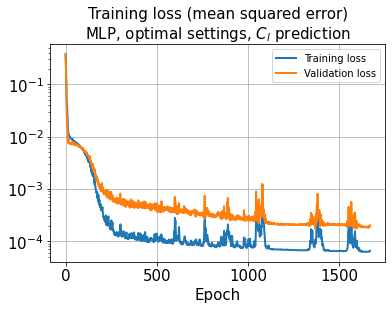

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

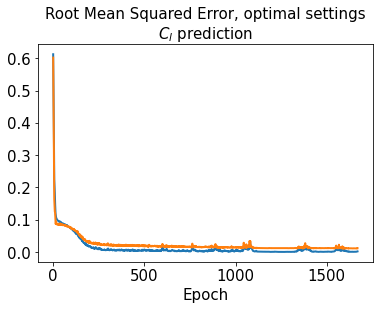

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

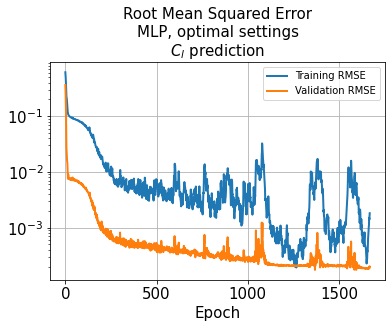

In [42]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 5ms/step - loss: 1.1715e-04 - rmse: 0.0071


In [44]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 28ms/step - loss: 4.3402e-04 - rmse: 0.0192


In [45]:
model_directory = "D:\\TrainedModels\\20221230"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230steady_MLP_parameter_test"+str(test_rate)+ "_" + str(n_units) +"units_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [47]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [48]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cl)-np.min(cl))+np.min(cl)

In [49]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [50]:
index_train = define_index(cl, y_train)
index_val = define_index(cl, y_val)
index_test = define_index(cl, y_test)

In [51]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


In [52]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [53]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.01098169018390329
0.3947138908173649


In [54]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.014954939975113796
0.6830258640855861


In [55]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.02806194456346666
1.0718193243614602


In [56]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [57]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [58]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [59]:
os.chdir(storage_dir)

In [60]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [61]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [62]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [63]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [64]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [65]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [66]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, steady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_l$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

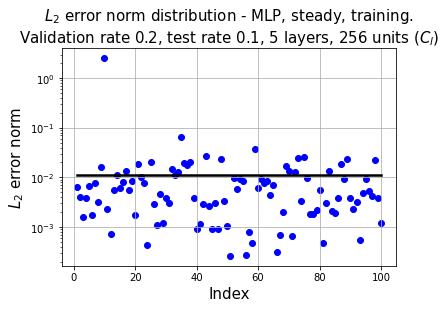

In [67]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

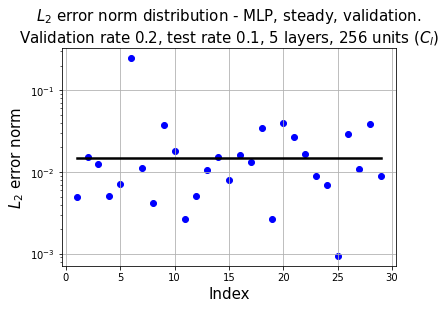

In [68]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

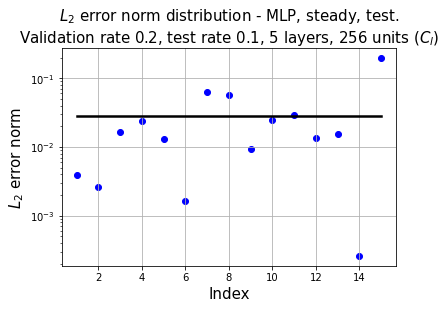

In [69]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [70]:
predicted = model.predict(x)

5/5 [==============================] - 0s 4ms/step


In [71]:
l2_error(predicted, y)

0.014733230844820073

In [72]:
l2_error(denormalize(predicted), denormalize(y))

0.014711265231791709

In [73]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [74]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [75]:
iTrain

array([[0.07829523],
       [0.20014634],
       [0.5428147 ],
       [0.72531959],
       [0.09905021],
       [0.22453571],
       [0.34748729],
       [0.57508838],
       [0.75696496],
       [0.81310017],
       [0.11326874],
       [0.36464193],
       [0.48266427],
       [0.59392803],
       [0.69343918],
       [0.7750257 ],
       [0.82894226],
       [0.83014806],
       [0.12056524],
       [0.24830382],
       [0.49178494],
       [0.60378922],
       [0.83728118],
       [0.83620876],
       [0.12068746],
       [0.248154  ],
       [0.60168919],
       [0.70062532],
       [0.78161168],
       [0.83380317],
       [0.83660121],
       [0.39837455],
       [0.72053083],
       [0.8019807 ],
       [0.85555728],
       [0.18051965],
       [0.31094384],
       [0.43777075],
       [0.55813943],
       [0.67045249],
       [0.76960343],
       [0.84977043],
       [0.89760389],
       [0.88764759],
       [0.33557902],
       [0.58501354],
       [0.69819459],
       [0.901

In [76]:
aa = aa*16

In [77]:
aa = np.ceil(aa)

In [89]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aVal, aTest, iTrain, iVal, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction (normalized), L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, beta=%d\nCL prediction (normalized), L2 error=%.4f'%(h[i], beta[i], l2_error_Cl)
    
    if i==0:
        title_Cl = title_0_Cl
        savename2 =  "ClComparison_NACA0018.jpg"
    else:
        title_Cl = title_n_Cl
        #savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    '''
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,0]/10, color='b', label='Training set')
    plt.scatter(aTest, iTest[:,0]/10, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
'''
    # CL graph plot
    plt.plot(alpha, denormalize(CL), 'k-', label='Ground truth')
    plt.plot(alpha, denormalize(cl), 'k--', label='Predicted value')
    plt.scatter(aTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(aVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(aTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$ (normalized)')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.0335


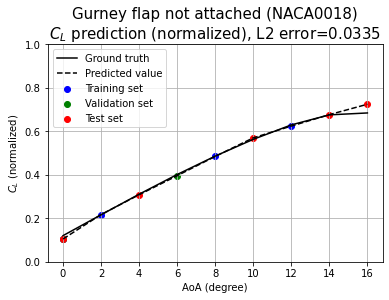

L2 error of Cl: 0.0097


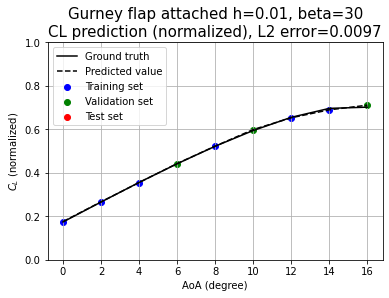

L2 error of Cl: 0.0127


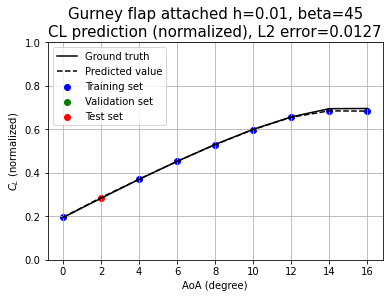

L2 error of Cl: 0.0177


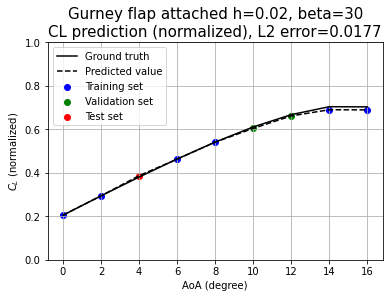

L2 error of Cl: 0.0200


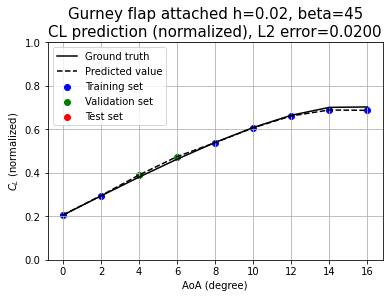

L2 error of Cl: 0.0222


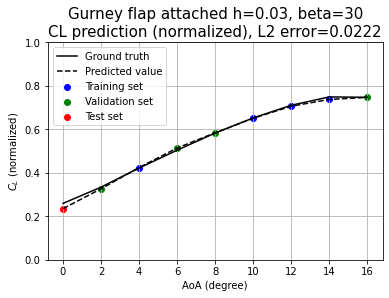

L2 error of Cl: 0.0033


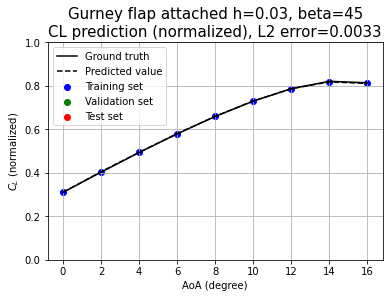

L2 error of Cl: 0.0157


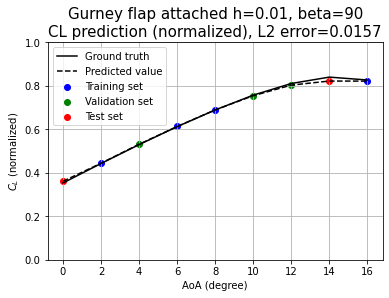

L2 error of Cl: 0.0123


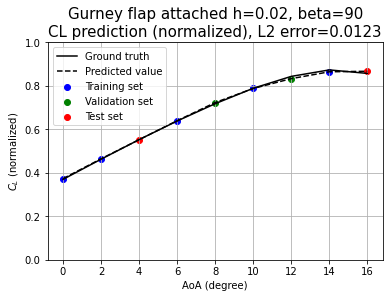

L2 error of Cl: 0.0130


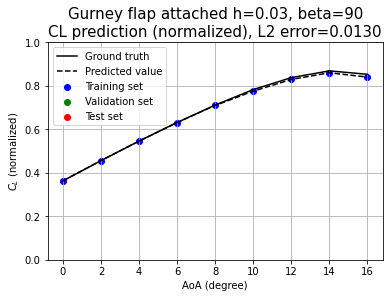

L2 error of Cl: 0.0163


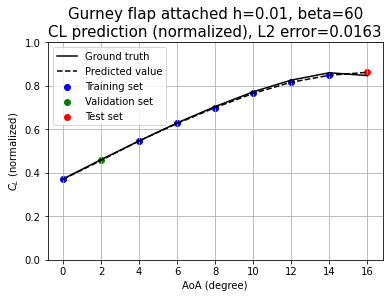

L2 error of Cl: 0.0084


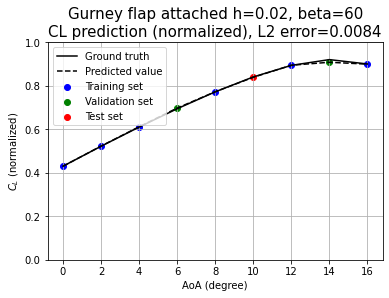

L2 error of Cl: 0.0043


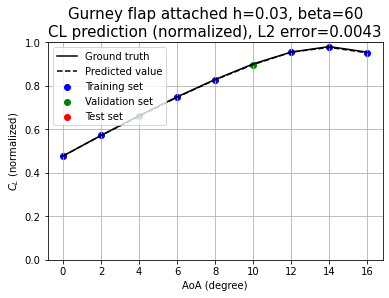

L2 error of Cl: 0.0059


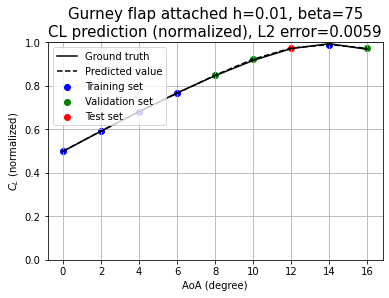

L2 error of Cl: 0.0094


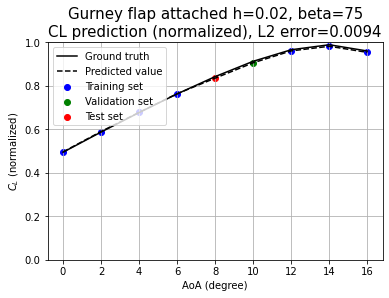

L2 error of Cl: 0.0233


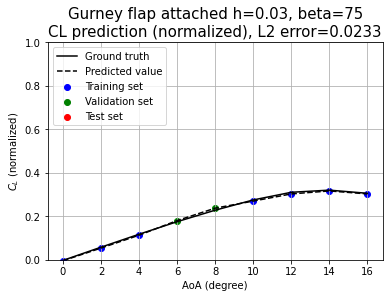

In [91]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]


for i in range(0, 16):
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    predictedValue = predicted[n_alpha*i:n_alpha*(i+1),:]
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    #l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),:]
    #cd = predicted[n_alpha*i:n_alpha*(i+1),0]/10
    
    CL = y[n_alpha*i:n_alpha*(i+1),:]
    #CD = y[n_alpha*i:n_alpha*(i+1),0]/10
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest_.append(predicted[index])
        
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for ii, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)
    aVal = np.array(alpha_val)
    aTest = np.array(alpha_test)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aVal, aTest, iTrain_, iVal_, iTest_)